## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

### Содержание


#### 1. Подготовка
* [Импорт datasets](#1)
* [Проверка на монотонность](#2)
* [Семплируем данные](#3)
* [Выводы](#4)

#### 2. Анализ 
* [Анализ графика ряда](#5)
* [Изучение тренда и сезонности](#6)
* [Выводы](#7)

#### 3. Обучение
* [Создания признаков](#8)
* [Деление датасета на выборки](#9)
* [LightGBM](#10)
* [RandomForest](#11)
* [KNeighbors](#12)
* [CatBoost](#13)
* [GradientBoosting](#14)
* [Итоговая таблица](#15)

#### 4. Тестирование
* [Проверка на тестовой выборке](#16)
* [График Target-Prediction](#17)
* [Выводы](#18)


# 1. Подготовка

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

import sklearn

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, TimeSeriesSplit,GridSearchCV
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.simplefilter('ignore')

<a id='1'></a>

In [3]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=['datetime']).sort_index()

In [4]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
taxi.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<a id='2'></a>

In [7]:
#Проверка на монотонность
taxi.index.is_monotonic

True

In [8]:
#пропуски
taxi.isnull().sum()

num_orders    0
dtype: int64

<a id='3'></a>

In [9]:
#Семплируем данные по часу, т.к. дальнейшее предсказание требуется делать на последующий час
taxi = taxi.resample('1H').sum()

### Выводы <a id='4'></a>

    исходные данные содержат 26496 строк
    временной промежуток данных начинается с 2018-03-01 00:00:00  и заканчивается 2018-08-31 23:50:00
    временной интревал наблюдений составляет 10 минут
    в данных пропусков нет
    данные расположены в хронологическом порядке (монотонны)

    Заменен тип данных столбца object на datetime
    Установлен индекс таблицы равным столбцу datetime

    Проведен ресемплинг данных по одному часу, данные агрегировали с помощью суммы

# 2. Анализ 

In [10]:
#функция для построения графиков
def draw(data, col):
    Q1 = np.quantile(data[col], 0.25, interpolation='midpoint')
    Q3 = np.quantile(data[col], 0.75, interpolation='midpoint')
    IQR = Q3 - Q1
    
    plt.figure(figsize=(15,.5))
    sns.boxplot(data[col]).set(xlim = [Q1-3*(Q3-Q1), Q3+3*(Q3-Q1)])
    plt.show()
    
    plt.figure(figsize=(15,3))
    sns.distplot(data[col])
    plt.show()

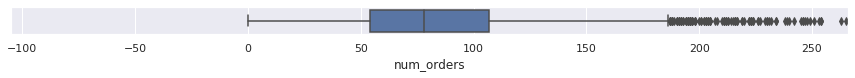

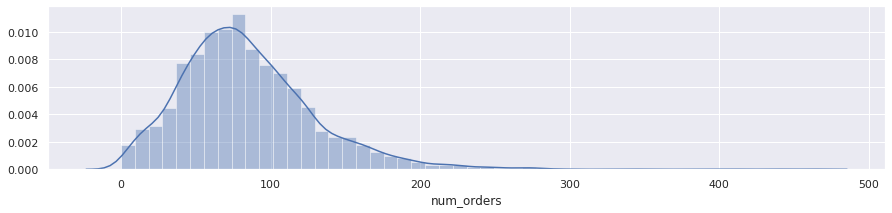

In [11]:
draw(taxi, 'num_orders')

In [12]:
#функция для построения графиков тренда, сезонности
def plot(data):
    decomposed = seasonal_decompose(data)
    plt.figure(figsize=(12, 10))
    plt.subplot(311)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')
    plt.subplot(312)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    #plt.subplot(313)
    #decomposed.resid.plot(ax=plt.gca())
    #plt.title('Residuals')
    plt.tight_layout()

<a id='5'></a>

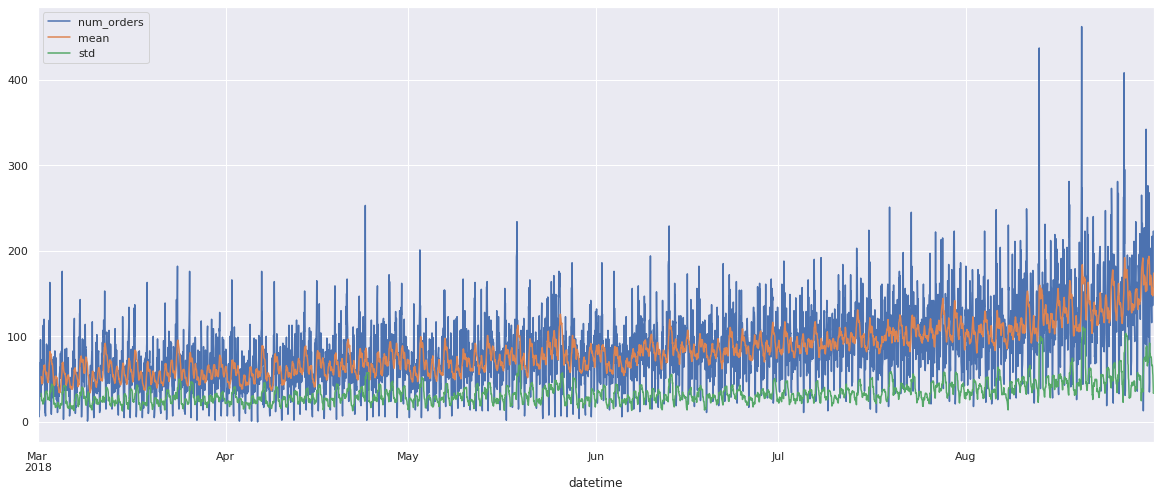

In [13]:
#Проверим, к какому типу принадлежит наш временной ряд.
taxi['mean'] = taxi['num_orders'].rolling(15).mean()
taxi['std'] = taxi['num_orders'].rolling(15).std()
taxi.plot(figsize=(20,8));

Скользящее среднее отклонение со временем изменяеся не слишком сильно. При этом среднее значение - достаточно высоко поднимется в августе.

In [14]:
taxi = taxi.drop(['mean','std'], axis=1)

<a id='6'></a>

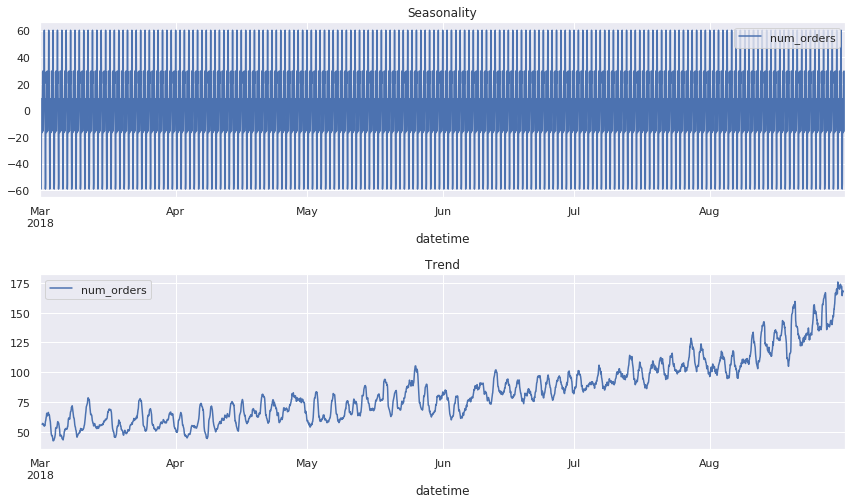

In [15]:
#Изучим тренд и сезонность
plot(taxi)

На данном графике заметен глобальный тренд увеличения числа заказов такси на протяжении всего изучаемого периода.
Колебяния сезонности на данном графике изучить невозможно, попробуем увеличить масштаб.

In [16]:
#Проведем ресемплинг, сгруппируем данные по дням и найдем скользящее среднее, чтобы оценить общую динамику изменений количества заказов
taxi_new = taxi.copy()
taxi_new = taxi_new.resample('1D').sum()
taxi_new['rolling_mean'] = taxi_new['num_orders'].rolling(5).mean()
taxi_new = taxi_new.dropna()

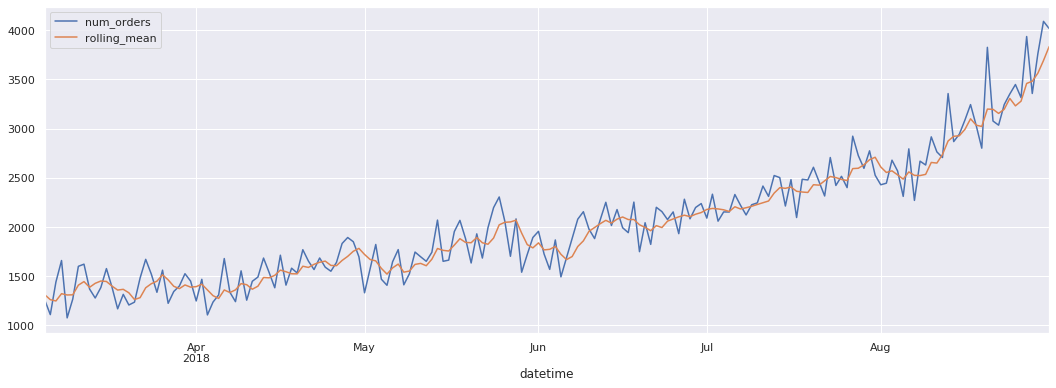

In [17]:
taxi_new[['num_orders', 'rolling_mean']].plot(figsize=(18, 6))

График стал более читабелен и из него можно сделать вывод, что присутсвует тренд на увеличение количества заказов такси от месяца к месяцу.

Проведем декомпозицию временного ряда, сгруппированного по дням на тренд и сезонную составляющую

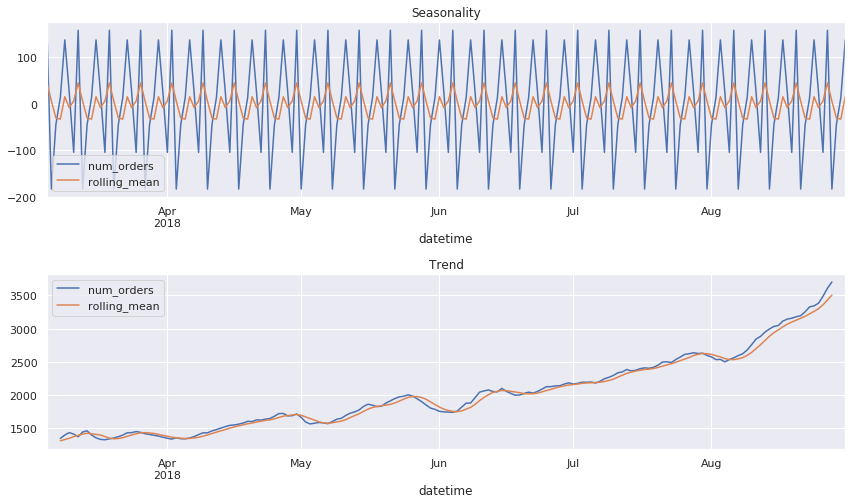

In [18]:
plot(taxi_new)

Линия тренда стала более гладкой и с явным направлением вверх.

График сезонной составляющей недостаточно читабелен, чтобы делать выводы

Text(0.5, 1.0, 'Seasonality')

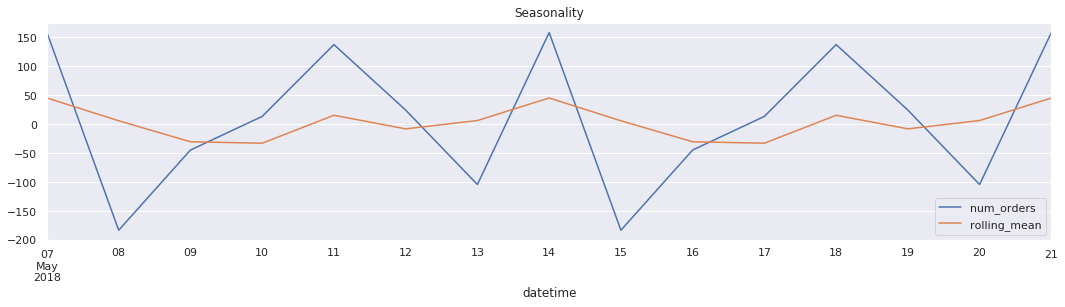

In [19]:
#посмотрим на графики по дням за две недели, например с 7 по 21 мая
plt.figure(figsize=(18, 4))
seasonal_decompose(taxi_new).seasonal['2018-05-07':'2018-05-21'].plot(ax=plt.gca())
plt.title('Seasonality')

    Наиболее часто такси заказывают по понедельникам, пятницам и четвергам
    Наименее часто во вторник и среду

Text(0.5, 1.0, 'Seasonality')

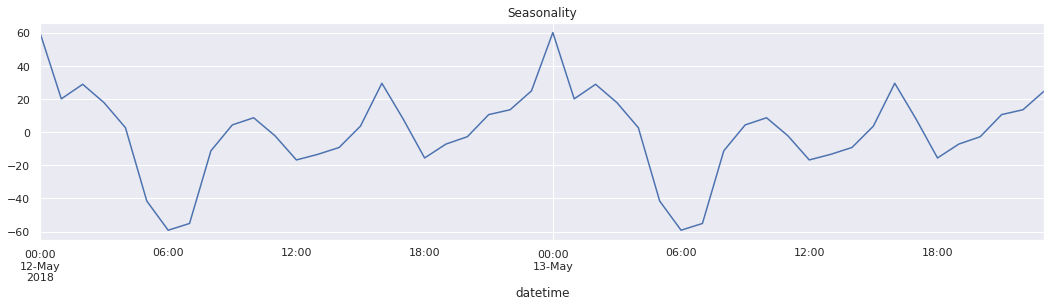

In [20]:
#Теперь изучим сезонную составляющую в почасовом графике заказов с 12 по 13 мая
plt.figure(figsize=(18, 4))
seasonal_decompose(taxi['num_orders']).seasonal['2018-05-12':'2018-05-13'].plot(ax=plt.gca())
plt.title('Seasonality')

    Из графика видно, что наиболее часто такси в аэропортах чаще заказывают в 00 ч.
    В 6-7 ч утра минимальное количество заказов
    В остальное время дня количество заказов меняется примерно на одном уровне.

### Выводы <a id='7'></a>

Проанализировали направление тренда и сезонность временного ряда:

    Есть общий тренда на увеличение количества заказов такси от месяца к месяцу, скорее всего влияет месячная сезонность, когда летом рост заказов, но сказать точно нельзя, т.к. данных у нас меньше года.
    Наиболее часто такси заказывают по понедельникам и пятницам и четвергам
    Наименее часто такси заказывают во вторник и среду
    Чаще всего такси заказывают около полуночи
    В 6-7 ч утра минимальное количество заказов такси


# 3. Обучение 

Создадим признаки для горизонта прогнозирования в один шаг

Создадим признаки:

    Календарные признаки - месяц, день, день недели, час;
    Отстающие значения;
    Скользящее среднее;

<a id='8'></a>

In [21]:
#функция для создания признаков
def make_features(taxi, max_lag, rolling_mean_size):
    taxi['month'] = taxi.index.month
    taxi['day'] = taxi.index.day
    taxi['dayofweek'] = taxi.index.dayofweek
    taxi['hour'] = taxi.index.hour
    
    for lag in range(1, max_lag + 1):
        taxi['lag_{}'.format(lag)] = taxi['num_orders'].shift(lag)

    taxi['rolling_mean'] = taxi['num_orders'].shift().rolling(rolling_mean_size).mean()
    taxi.dropna(inplace=True)

In [22]:
#Запустим функуцию со сдвигом = 10 шагов
make_features(taxi, 10, 10)

In [23]:
display(taxi.head(10))

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,,
2018-03-01 10:00:00,64,3,1,3,10,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,52.5
2018-03-01 11:00:00,96,3,1,3,11,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,46.5
2018-03-01 12:00:00,30,3,1,3,12,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,47.6
2018-03-01 13:00:00,32,3,1,3,13,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,43.5
2018-03-01 14:00:00,48,3,1,3,14,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,40.1
2018-03-01 15:00:00,66,3,1,3,15,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,40.6
2018-03-01 16:00:00,43,3,1,3,16,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,46.6
2018-03-01 17:00:00,44,3,1,3,17,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,49.7
2018-03-01 18:00:00,73,3,1,3,18,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,52.6


In [24]:
#Разделим датасет на выборки
taxi_features = taxi.drop(['num_orders'], axis=1)
taxi_target = taxi['num_orders']

In [25]:
#taxi_frest, taxi_ftest, taxi_trest, taxi_ttest = train_test_split(
#    taxi_features, taxi_target, test_size=0.1, shuffle=False, random_state=12345)
#taxi_ftrain, taxi_fvalid, taxi_ttrain, taxi_tvalid = train_test_split(
#    taxi_frest, taxi_trest, test_size=0.11, shuffle=False, random_state=12345)

taxi_ftrain, taxi_ftest, taxi_ttrain, taxi_ttest = train_test_split(
    taxi_features, taxi_target, test_size=0.1, shuffle=False, random_state=12345)

In [26]:
#проверим выборки
display(taxi_ftrain.shape, taxi_ftrain.index.min(), taxi_ftrain.index.max())
#display(taxi_fvalid.shape, taxi_fvalid.index.min(), taxi_fvalid.index.max())
display(taxi_ftest.shape, taxi_ftest.index.min(), taxi_ftest.index.max())

(3965, 15)

Timestamp('2018-03-01 10:00:00')

Timestamp('2018-08-13 14:00:00')

(441, 15)

Timestamp('2018-08-13 15:00:00')

Timestamp('2018-08-31 23:00:00')

2 последовательные выборки в хронологическом порядке.


In [27]:
res=[]
res_tst=[]

In [28]:
def gridsearch_result(model, parameters, f, t, scorer):
    gridsearch = GridSearchCV(estimator=model, param_grid = parameters, refit=False, scoring=scorer, cv=TimeSeriesSplit(n_splits=2))
    gridsearch = gridsearch.fit(f, t)
    optimal_score = gridsearch.best_score_
    optimal_parameters = gridsearch.best_params_
    print('Лучшие гиперпараметры: ', optimal_parameters)
    print('Лучшее RMSE: {:.2f}'.format((-optimal_score) ** 0.5))
    
    res.append([(-optimal_score) ** 0.5, optimal_parameters])

In [29]:
def mlmodel(model, ft, tt, fv, tv):
    model = model
    model.fit(ft, tt)
    prediction_tr = model.predict(ft)
    prediction = model.predict(fv)

    res_tst.append([mean_squared_error(tv, prediction) ** 0.5])

### LightGBM <a id='10'></a>

In [30]:
parameters = {
        'n_estimators' : range(50, 101, 10),
        'max_depth' : range(5, 15, 2),
        'verbose' : [0],
        'random_state' : [12345] 
        }
best = gridsearch_result(LGBMRegressor(), parameters, taxi_ftrain, taxi_ttrain, 'neg_mean_squared_error')

Лучшие гиперпараметры:  {'max_depth': 11, 'n_estimators': 60, 'random_state': 12345, 'verbose': 0}
Лучшее RMSE: 27.63


### RandomForest <a id='11'></a>

In [31]:
parameters = {
        'n_estimators' : range(50, 101, 10),
        'max_depth' : range(5, 15, 2),
        'verbose' : [0],
        'random_state' : [12345] 
        }
gridsearch_result(RandomForestRegressor(), parameters, taxi_ftrain, taxi_ttrain, 'neg_mean_squared_error')

Лучшие гиперпараметры:  {'max_depth': 13, 'n_estimators': 60, 'random_state': 12345, 'verbose': 0}
Лучшее RMSE: 28.37


### KNeighbors <a id='12'></a>

In [32]:
parameters = {
        'n_neighbors': range(3,10),
        'metric' : ['minkowski', 'manhattan'],
        'leaf_size' : [20,25,30,35],
        'algorithm' : ['auto','ball_tree','kd_tree']
        }
gridsearch_result(KNeighborsRegressor(), parameters, taxi_ftrain, taxi_ttrain, 'neg_mean_squared_error')

Лучшие гиперпараметры:  {'algorithm': 'auto', 'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 9}
Лучшее RMSE: 34.71


### CatBoost <a id='13'></a>

In [33]:
parameters = {
        'n_estimators' : [50, 100], 
        'max_depth' : [5, 7, 10], 
        'verbose' : [0], 
        'random_state' : [12345]
        }
gridsearch_result(CatBoostRegressor(), parameters, taxi_ftrain, taxi_ttrain, 'neg_mean_squared_error')

Лучшие гиперпараметры:  {'max_depth': 7, 'n_estimators': 100, 'random_state': 12345, 'verbose': 0}
Лучшее RMSE: 31.11


### GradientBoosting <a id='14'></a>

In [34]:
parameters = {
        'n_estimators' : range(50, 101, 10),
        'max_depth' : range(5, 15, 2),
        'verbose' : [0],
        'random_state' : [12345] 
        }
gridsearch_result(GradientBoostingRegressor(), parameters, taxi_ftrain, taxi_ttrain, 'neg_mean_squared_error')

Лучшие гиперпараметры:  {'max_depth': 5, 'n_estimators': 80, 'random_state': 12345, 'verbose': 0}
Лучшее RMSE: 28.51


<a id='15'></a>

In [35]:
result = pd.DataFrame(data=res, columns=['rmse', 'optimal_parameters']).rename(index={0: 'LightGBM', 1: 'RandomForest', 2: 'KNeighbors', 3: 'CatBoost', 4: 'GradientBoosting'})
display(result)

,rmse,optimal_parameters
LightGBM,27.632946,"{'max_depth': 11, 'n_estimators': 60, 'random_..."
RandomForest,28.371571,"{'max_depth': 13, 'n_estimators': 60, 'random_..."
KNeighbors,34.714051,"{'algorithm': 'auto', 'leaf_size': 20, 'metric..."
CatBoost,31.112541,"{'max_depth': 7, 'n_estimators': 100, 'random_..."
GradientBoosting,28.512973,"{'max_depth': 5, 'n_estimators': 80, 'random_s..."


Наилучший результат RMSE показала модель LightGBM = 25.890376

# 4. Тестирование <a id='16'></a>

In [36]:
mlmodel(LGBMRegressor(max_depth=11, n_estimators=60, random_state=12345, verbose=0), taxi_ftrain, taxi_ttrain, taxi_ftest, taxi_ttest)

In [37]:
mlmodel(RandomForestRegressor(max_depth=13, n_estimators=60, random_state=12345, verbose=0), taxi_ftrain, taxi_ttrain, taxi_ftest, taxi_ttest)

In [38]:
mlmodel(KNeighborsRegressor(algorithm='auto', leaf_size=20, metric='manhattan', n_neighbors=9), taxi_ftrain, taxi_ttrain, taxi_ftest, taxi_ttest)

In [39]:
mlmodel(CatBoostRegressor(max_depth=7, n_estimators=100, random_state=12345, verbose=0), taxi_ftrain, taxi_ttrain, taxi_ftest, taxi_ttest)

In [40]:
mlmodel(GradientBoostingRegressor(max_depth=5, n_estimators=80, random_state=12345, verbose=0), taxi_ftrain, taxi_ttrain, taxi_ftest, taxi_ttest)

In [41]:
result_tst = pd.DataFrame(data=res_tst, columns=['rmse']).rename(index={0: 'LightGBM', 1: 'RandomForest', 2: 'KNeighbors', 3: 'CatBoost', 4: 'GradientBoosting'})
display(result_tst)

,rmse
LightGBM,43.437109
RandomForest,44.633221
KNeighbors,58.364862
CatBoost,53.011270
GradientBoosting,43.189159


Необходимый результат RMSE < 48 на тестовой выборке показали модель LightGBM = 43.437109, GradientBoosting = 43.189159, RandomForest = 44.633221

<a id='17'></a>

In [42]:
model = LGBMRegressor(max_depth=11, n_estimators=60, random_state=12345, verbose=0)
model.fit(taxi_ftrain, taxi_ttrain)
prediction_tr = model.predict(taxi_ftrain)
prediction = model.predict(taxi_ftest)

In [43]:
frame = {'Target':taxi_ttest, 'Prediction':prediction}

In [44]:
r = pd.DataFrame(frame)

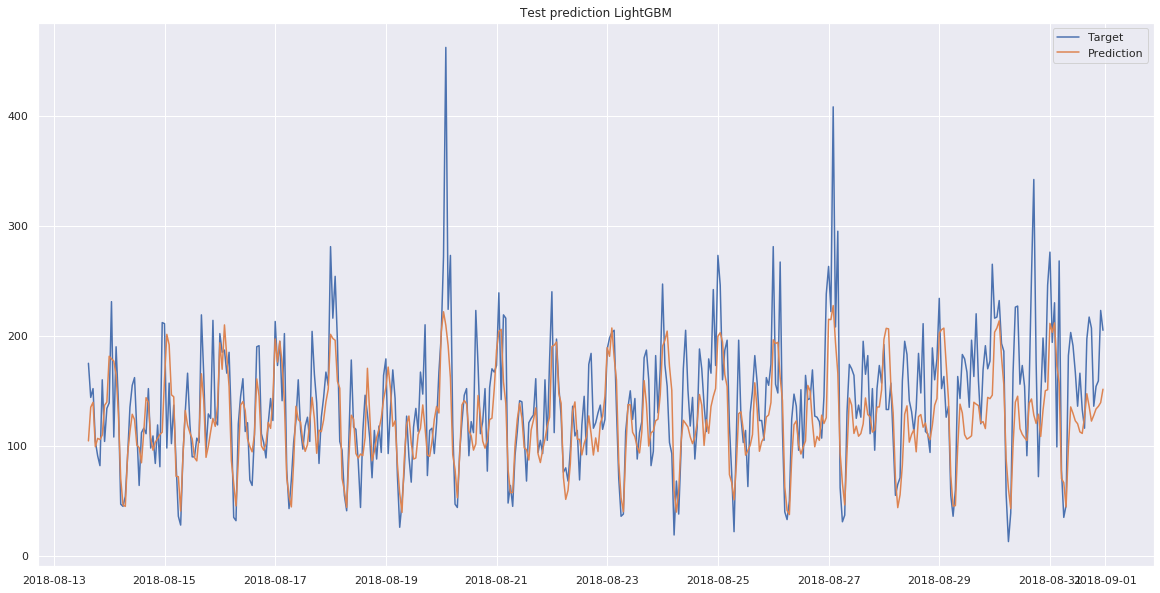

In [45]:
plt.figure(figsize=(20,10))
plt.title('Test prediction LightGBM')
plt.plot(r)
plt.legend(['Target', 'Prediction'])

Полученная модель неплохо повторяет target

### Выводы <a id='18'></a>

    Обучили 5 моделей и 3 из них показали на тестовой выборке RMSE < 48
    Наилучший результат RMSE показали модели LGBMRegressor и GradientBoosting
    Есть общий тренда на увеличение количества заказов такси от месяца к месяцу
    Наиболее часто такси заказывают по понедельникам и пятницам и четвергам, наименее часто во вторник и среду
    Чаще всего такси заказывают около полуночи, а в 6-7 ч утра минимальное количество заказов
    
    Можно сделать вывод о необходимости усиления рабочих смен таксистов именно указанное время.